# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 50 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 15 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 14 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 16 Dynapse1DevKit serial_number 00000007
[4]:  Bus 1 Device 127 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 124 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [33]:
schip = score = 0
sid = 200
chip = core_e = 0
core_i = 1
core_i2 = 2

duration = 2

neuron_ids_E1 = np.arange(1,9)
neuron_ids_E2 = neuron_ids_E1 + 3*neuron_ids_E1.size
neuron_ids_I1 = 1
neuron_ids_I2 = 2
neuron_id_Icommon = 1

# init a network generator
net = network.DynapseNetworkGenerator()

spikegen = net.get_spikegen(schip, score, sid)

neurons_E1 = net.get_neurons(chip, core_e, neuron_ids_E1)
neurons_I1 = net.get_neuron(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e, neuron_ids_E2)
neurons_I2 = net.get_neuron(chip, core_i, neuron_ids_I2)
neuron_Icommon = net.get_neuron(chip, core_i2, neuron_id_Icommon)

net.add_connections_one_to_all(spikegen, neurons_E1, network.SYNAPSE_NMDA, weight=2)
net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_one(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_one_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_one_to_all(spikegen, neurons_E2, network.SYNAPSE_NMDA, weight=2)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_one(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_one_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=8)

# # coupling
# net.add_connections_all_to_one(neurons_E1, neuron_Icommon, network.SYNAPSE_AMPA)
# net.add_connections_all_to_one(neurons_E2, neuron_Icommon, network.SYNAPSE_AMPA)
# net.add_connections_one_to_all(neuron_Icommon, neurons_E1, network.SYNAPSE_GABA_A)
# net.add_connections_one_to_all(neuron_Icommon, neurons_E2, network.SYNAPSE_GABA_A)
# cheating...
# net.add_connections_one_to_all(neurons_I2, neurons_E1, network.SYNAPSE_AMPA)
# net.add_connections_one_to_all(neurons_I1, neurons_E2, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons_E1, neurons_E2, [neurons_I1], [neurons_I2], [neuron_Icommon])

model.apply_configuration(net.get_config())

rate = 20
poisson_gen = dynapse.get_poisson_spikegen(rate, schip, score, sid)

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


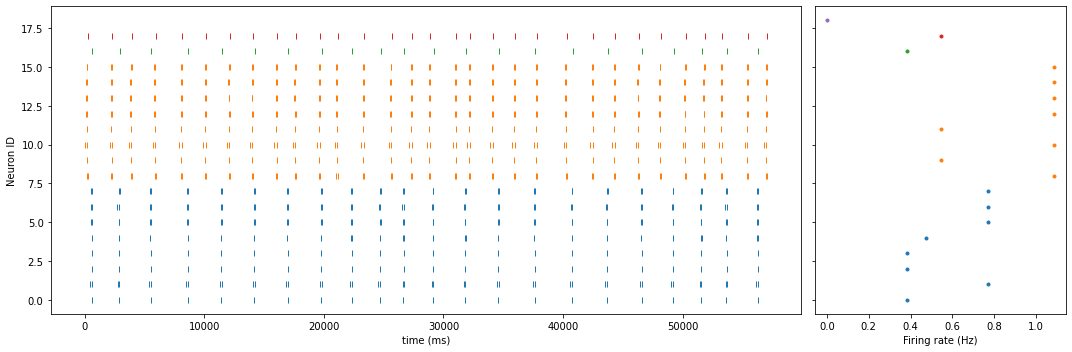

In [34]:
# set params
parameters.set_all_default_params(model)

# Core e parameters
parameters.set_param(model, parameters.AMPA_WEIGHT, (6,40), chip, core_e)

parameters.set_param(model, parameters.NMDA_WEIGHT, (5,60), chip, core_e)

parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,200), chip, core_e)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,80), chip, core_e)

parameters.set_param(model, parameters.GABA_A_LEAKAGE, (2,40), chip, core_e)
parameters.set_param(model, parameters.GABA_A_WEIGHT, (7,200), chip, core_e)

# Core i parameters
parameters.set_param(model, parameters.AMPA_WEIGHT, (5,150), chip, core_i)

# # # Core i_2 parameters
parameters.set_param(model, parameters.AMPA_LEAKAGE, (5,27), chip, core_i2)
parameters.set_param(model, parameters.AMPA_GAIN, (6,70), chip, core_i2)
parameters.set_param(model, parameters.AMPA_WEIGHT, (1,10), chip, core_i2)

dynapse.start_graph()

poisson_gen.start()
spikes = dynapse.run_simulation(60)
poisson_gen.stop()

# plotting.plot_spikes(dynapse, spikes)
plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,5))


In [ ]:
dynapse.stop_graph()